# Online Joint State and Parameters Estimation for HAR SSM
State space model
\begin{align*}
    &\theta_{t}^{(1)} = A(\theta_t^{(2)})\theta_{t-1}^{(1)} + \mathbf{c}v^{(1)}_t  \\
    &\theta_t^{(0)} = A(\theta_{t}^{(1)})\theta_{t-1}^{(0)} + \mathbf{c}v^{(0)}_{t} \\
    &y_t = \mathbf{c}^{\top} \theta_t^{(0)} + w_t
\end{align*}

where
\begin{align*}
    &A(\theta) = 
    \begin{bmatrix}
         \theta^{\top}  \\
         \mathbf{I}_{M-1} \quad \mathbf{0}
    \end{bmatrix}
    \, , \quad
    \mathbf{I}_M = 
    \begin{bmatrix}
        1_1 & 0 &  \dots & 0 \\ 
        0 & 1_2 &  \dots & 0 \\   
        \vdots &  \vdots & \ddots & \vdots \\
        0 & 0  & \dots & 1_{M}
    \end{bmatrix} \\ \\
    &\theta^{(i)}_t = (x_t^{(i)}, x_{t-1}^{(i)}, \dots, x_{t-M+1}^{(i)})^{\top}\,.
\end{align*}

Note: we clamp $\gamma_y = \frac{1}{2}$

![](ffgs/HAR-online.png)

In [2]:
using ProgressMeter
using Revise
using ForneyLab
using Random
using Plots
using LaTeXStrings
using StatsPlots
include("data/DataAR.jl")
include("ARNode/ARNode.jl")
include("helpers/functions.jl")
using .ARNode, .DataAR
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [17]:
Random.seed!(42)

HARorder = 1

v_θ1 = 0.5
v_x = 1.0

dataHAR = generateHAR(1000, HARorder, levels=2, nvars=[v_θ1, v_x], stat=true)
coefs = dataHAR[1]
θ = [θ[1] for θ in dataHAR[2]]
x = [x[1] for x in dataHAR[3]]

# Observations
v_y = 2.0
y = [xi[1] + sqrt(v_y)*randn() for xi in dataHAR[3]];

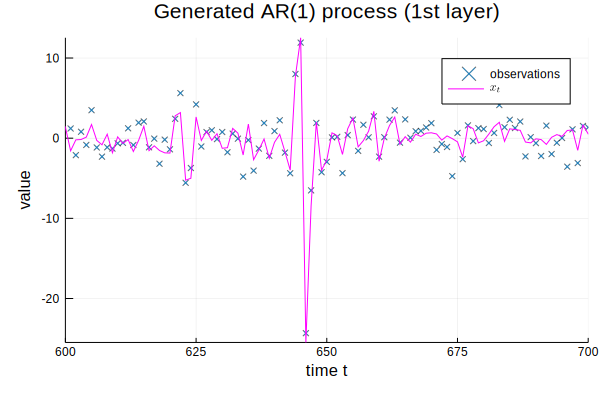

In [18]:
# Plotting the data
from = 600; upto = 700;
plot(xlims=(from, upto), ylims=(minimum(x[from:upto]), maximum(x[from:upto])))
scatter!(y, markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x, color=:magenta, label=L"x_t", title="Generated AR($HARorder) process (1st layer)")

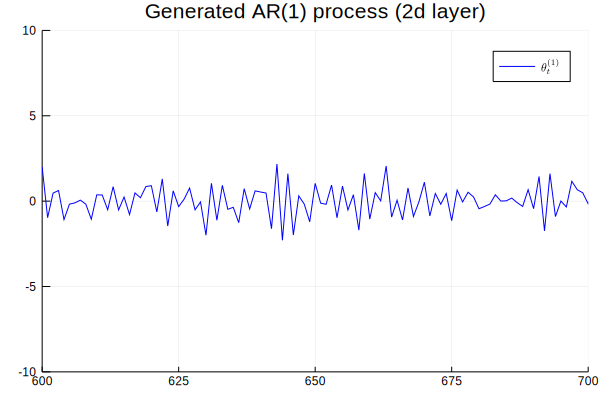

In [19]:
plot(xlims=(from, upto), ylims=(-10, 10))
plot!(θ, color=:blue, label=L"\theta_t^{(1)}", title="Generated AR($HARorder) process (2d layer)")

In [20]:
# Creating the graph
g = FactorGraph()

# Upper layer
@RV m_θ2
@RV w_θ2
@RV θ2 ~ GaussianMeanPrecision(m_θ2, w_θ2)
@RV a_θ1
@RV b_θ1
@RV w_θ1 ~ Gamma(a_θ1, b_θ1)
@RV m_θ1_t_prev
@RV w_θ1_t_prev
@RV θ1_t_prev ~ GaussianMeanPrecision(m_θ1_t_prev, w_θ1_t_prev)
@RV θ1_t ~ Autoregression(θ2, θ1_t_prev, w_θ1)

# Second layer
@RV a_x
@RV b_x
@RV w_x ~ Gamma(a_x, b_x)
@RV m_x_t_prev
@RV w_x_t_prev
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ Autoregression(θ1_t, x_t_prev, w_x)

# Observation
c = zeros(HARorder); c[1] = 1;
@RV y_t ~ GaussianMeanPrecision(dot(c, x_t), placeholder(:w_y_t))

# Placeholders for prior of upper layer
placeholder(m_θ2, :m_θ2, dims=(HARorder,))
placeholder(w_θ2, :w_θ2, dims=(HARorder, HARorder))
placeholder(a_θ1, :a_θ1)
placeholder(b_θ1, :b_θ1)
placeholder(m_θ1_t_prev, :m_θ1_t_prev, dims=(HARorder,))
placeholder(w_θ1_t_prev, :w_θ1_t_prev, dims=(HARorder, HARorder))

# Placeholders for prior of bottom layer
placeholder(a_x, :a_x)
placeholder(b_x, :b_x)
placeholder(m_x_t_prev, :m_x_t_prev, dims=(HARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(HARorder, HARorder))

# Placeholder for data
placeholder(y_t, :y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 216225837784907521 -->
 
 216225837784907521 
 
 dot 
 dotproduct_1 
 
<!-- 913686318269286414 -->
 
 913686318269286414 
 
 clamp_1 
 
<!-- 216225837784907521--913686318269286414 -->
 
 216225837784907521--913686318269286414 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 5991945730246364296 -->
 
 5991945730246364296 
 
 AR 
 autoregression_2 
 
<!-- 216225837784907521--5991945730246364296 -->
 
 216225837784907521--5991945730246364296 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 3475026133419053797 -->
 
 3475026133419053797 
 
 placeholder_b_x 
 
<!-- 17602171061152335427 -->
 
 17602171061152335427 
 
 Gam 
 gamma_2 
 
<!-- 3475026133419053797--17602171061152335427 -->
 
 3475026133419053797--17602171061152335427 
 
 b_x 
 3 b 
 1 out 
 
<!-- 4144393204810066221 -->
 
 4144393204810066221 
 
 placeholder_m_θ2 
 
<!-- 12219374873292262546 -->
 
 12219374873292262546 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 4144393204810066221--12219374873292262546 -->
 
 4144393204810066221--12219374873292262546 
 
 m_θ2 
 2 m 
 1 out 
 
<!-- 15537574912363303775 -->
 
 15537574912363303775 
 
 placeholder_y_t 
 
<!-- 10307787346703487206 -->
 
 10307787346703487206 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 15537574912363303775--10307787346703487206 -->
 
 15537574912363303775--10307787346703487206 
 
 y_t 
 1 out 
 1 out 
 
<!-- 11501359083112915137 -->
 
 11501359083112915137 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 11809792601224165650 -->
 
 11809792601224165650 
 
 placeholder_w_y_t 
 
<!-- 8149092495176955355 -->
 
 8149092495176955355 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 11213023078603389782 -->
 
 11213023078603389782 
 
 placeholder_b_θ1 
 
<!-- 8768656622607792824 -->
 
 8768656622607792824 
 
 Gam 
 gamma_1 
 
<!-- 11213023078603389782--8768656622607792824 -->
 
 11213023078603389782--8768656622607792824 
 
 b_θ1 
 3 b 
 1 out 
 
<!-- 14814302851024756152 -->
 
 14814302851024756152 
 
 placeholder_a_θ1 
 
<!-- 14814302851024756152--8768656622607792824 -->
 
 14814302851024756152--8768656622607792824 
 
 a_θ1 
 2 a 
 1 out 
 
<!-- 12324389954800221700 -->
 
 12324389954800221700 
 
 placeholder_a_x 
 
<!-- 12324389954800221700--17602171061152335427 -->
 
 12324389954800221700--17602171061152335427 
 
 a_x 
 2 a 
 1 out 
 
<!-- 1846972245289390020 -->
 
 1846972245289390020 
 
 placeholder_w_θ2 
 
<!-- 1846972245289390020--12219374873292262546 -->
 
 1846972245289390020--12219374873292262546 
 
 w_θ2 
 3 w 
 1 out 
 
<!-- 10307787346703487206--216225837784907521 -->
 
 10307787346703487206--216225837784907521 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 10307787346703487206--11809792601224165650 -->
 
 10307787346703487206--11809792601224165650 
 
 w_y_t 
 1 out 
 3 w 
 
<!-- 17824517234008601836 -->
 
 17824517234008601836 
 
 placeholder_w_x_t_prev 
 
<!-- 17824517234008601836--8149092495176955355 -->
 
 17824517234008601836--8149092495176955355 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 9215798523369024209 -->
 
 9215798523369024209 
 
 placeholder_m_x_t_prev 
 
<!-- 9215798523369024209--8149092495176955355 -->
 
 9215798523369024209--8149092495176955355 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 1199674680764751391 -->
 
 1199674680764751391 
 
 AR 
 autoregression_1 
 
<!-- 1199674680764751391--11501359083112915137 -->
 
 1199674680764751391--11501359083112915137 
 
 θ1_t_prev 
 1 out 
 2 x 
 
<!-- 1199674680764751391--12219374873292262546 -->
 
 1199674680764751391--12219374873292262546 
 
 θ2 
 1 out 
 3 θ 
 
<!-- 1199674680764751391--8768656622607792824 -->
 
 1199674680764751391--8768656622607792824 
 
 w_θ1 
 1 out 
 4 γ 
 
<!-- 16503126044622854830 -->
 
 16503126044622854830 
 
 placeholder_w_θ1_t_prev 
 
<!-- 16503126044622854830--11501359083112915137 -->
 
 16503126044622854830--11501359083112915137 
 
 w_θ1

In [21]:
# Specify recognition factorization
q = RecognitionFactorization(θ1_t, θ2, θ1_t_prev, w_θ1, x_t, x_t_prev, w_x,
                             ids=[:θ1_t :θ2 :θ1_t_prev :W_θ1 :X_t :X_t_prev :W_x])

algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [22]:
# Storage for upper layer
m_θ1 = Vector{Vector{Float64}}(undef, length(y))
w_θ1 = Vector{Array{Float64, 2}}(undef, length(y))
m_θ1_prev = Vector{Vector{Float64}}(undef, length(y))
w_θ1_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_θ2 = Vector{Vector{Float64}}(undef, length(y))
w_θ2 = Vector{Array{Float64, 2}}(undef, length(y))
a_θ1 = Vector{Float64}(undef, length(y))
b_θ1 = Vector{Float64}(undef, length(y))

# Storage for bottom layer
m_x = Vector{Vector{Float64}}(undef, length(y))
w_x = Vector{Array{Float64, 2}}(undef, length(y))
a_x = Vector{Float64}(undef, length(y))
b_x = Vector{Float64}(undef, length(y))

# Define values for upper layer
m_θ2_0 = ones(HARorder)
w_θ2_0 = diagAR(HARorder)
a_θ1_0 = 0.00001
b_θ1_0 = 0.00001
m_θ1_prev_0 = ones(HARorder)
w_θ1_prev_0 = diagAR(HARorder)
m_θ1_t_0 = ones(HARorder)
w_θ1_t_0 = diagAR(HARorder)

# Define values for bottom layer
a_x_0 = tiny
b_x_0 = 1.0
m_x_t_prev_0 = zeros(HARorder)
w_x_t_prev_0 = diagAR(HARorder)

# Priors upper layer
m_θ2_min = m_θ2_0
w_θ2_min = w_θ2_0
a_θ1_min = a_θ1_0
b_θ1_min = b_θ1_0
m_θ1_t_prev_min = m_θ1_prev_0
w_θ1_t_prev_min = w_θ1_prev_0

# Priors bottom layer
a_x_min = a_x_0
b_x_min = b_x_0
m_θ1_t_min = m_θ1_t_0
w_θ1_t_min = w_θ1_t_0
m_x_t_prev_min = m_x_t_prev_0
w_x_t_prev_min = w_x_t_prev_0;

In [23]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for scores
FHAR = []
logPDFsHAR = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    # Upper Layer
    marginals[:θ2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ2_min, w=w_θ2_min)
    marginals[:θ1_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_prev_min, w=w_θ1_t_prev_min)
    marginals[:θ1_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_min, w=w_θ1_t_min)
    marginals[:w_θ1] = ProbabilityDistribution(Univariate, Gamma, a=a_θ1_min, b=b_θ1_min)
    # Bottom Layer
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w_x] = ProbabilityDistribution(Univariate, Gamma, a=a_x_min, b=b_x_min)

    global m_θ2_min, w_θ2_min, m_θ1_t_prev_min, w_θ1_t_prev_min, a_θ1_min, b_θ1_min,
           m_θ1_t_min, w_θ1_t_min, m_x_t_prev_min, w_x_t_prev_min, a_x_min, b_x_min, data

    for i = 1:n_its
        data = Dict(:y_t => y[t],
                    :w_y_t => v_y^-1,
                    :m_θ2 => m_θ2_min,
                    :w_θ2 => w_θ2_min,
                    :m_θ1_t_prev => m_θ1_t_prev_min,
                    :w_θ1_t_prev => w_θ1_t_prev_min,
                    :a_θ1 => a_θ1_min,
                    :b_θ1 => b_θ1_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_x => a_x_min,
                    :b_x => b_x_min)

        stepX_t!(data, marginals)
        stepX_t_prev!(data, marginals)
        stepW_x!(data, marginals)
        stepθ1_t!(data, marginals)
        stepθ1_t_prev!(data, marginals)
        stepW_θ1!(data, marginals)
        stepθ2!(data, marginals)

        m_θ1_prev[t] = unsafeMean(marginals[:θ1_t_prev])
        w_θ1_prev[t] = unsafePrecision(marginals[:θ1_t_prev])
        m_θ1[t] = unsafeMean(marginals[:θ1_t])
        w_θ1[t] = unsafePrecision(marginals[:θ1_t])
        m_θ2[t] = unsafeMean(marginals[:θ2])
        w_θ2[t] = unsafePrecision(marginals[:θ2])
        a_θ1[t] = marginals[:w_θ1].params[:a]
        b_θ1[t] = marginals[:w_θ1].params[:b]
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        a_x[t] = marginals[:w_x].params[:a]
        b_x[t] = marginals[:w_x].params[:b]

        m_θ2_min = m_θ2[t]
        w_θ2_min = w_θ2[t]
        m_θ1_t_prev_min = m_θ1_prev[t]
        w_θ1_t_prev_min = w_θ1_prev[t]
        m_θ1_t_min = m_θ1[t]
        m_θ1_t_min = m_θ1[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_θ1_min = a_θ1[t]
        b_θ1_min = b_θ1[t]
        a_x_min = a_x[t]
        b_x_min = b_x[t]
    end
    push!(logPDFsHAR, logPDF(x[t], m_x[t][1], w_x[t][1]^-1))
    if HARorder == 1
        push!(FHAR, (freeEnergy(data, marginals)))
    end
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:02


In [24]:
## Plotting AR coefs first layer
# Extracting estimates for x_t (first component of vector x̄_t)
m_xt = [m_x[1] for m_x in m_x]
v_xt = [v_x[1]^-1 for v_x in w_x]

# Extracting estimates for θ2_t (first component of vector θ̂2_t)
m_θ1t = [m_θ1[1] for m_θ1 in m_θ1]
v_θ1t = [v_x[1]^-1 for v_x in w_θ1];

In [25]:
println("Upper layer inference\n=======\n")

println("Coefs \n=========")
println("Estimated mean", unsafeMean(marginals[:θ2]))
println("Estimated variance", unsafeCov(marginals[:θ2]))
println("True ", coefs)

println("\nProcess noise variance\n=========")
println("Estimated ", mean(marginals[:w_θ1])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:θ1_t]))
println("Var ", var(marginals[:θ1_t]))

Upper layer inference

Coefs 
Estimated mean[2.04479]
Estimated variance[0.107546]
True [-0.556027]

Process noise variance
Estimated 0.9126914989168409
True 1.0

State
Mean [0.0976238]
Var [0.883747]


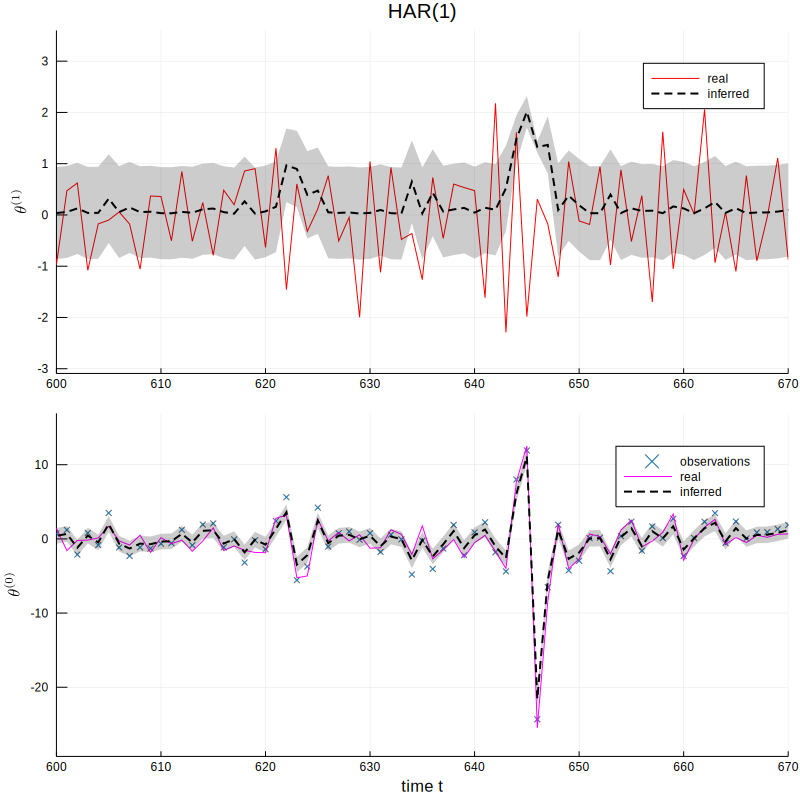

In [26]:
from = 600
upto = 670
scatter(y, markershape = :xcross, markeralpha = 0.6, xlims=(from, upto),
        ylims=(minimum(y[from:upto]) - 5, maximum(y[from:upto]) + 5),
        markersize = 2, xlabel="time t", ylabel=L"\theta^{(0)}", label="observations")
plot!(x, color=:magenta, label="real", title="")
pHAR = plot!(m_xt, ribbon=sqrt.(v_xt),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")

plot(xlims=(from, upto), ylabel=L"\theta^{(1)}")
plot!(θ[2:end], color=:red, label="real", title="Inference 2d layer")
pAR = plot!(m_θ1t, ribbon=sqrt.(v_θ1t),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred", title="HAR(1)")

plot(pAR, pHAR, layout=(2,1), size=(800, 800))

# AR(1) model
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = \theta^{(0)}x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where $\gamma_y^{-1} = 2.0$

In [27]:
include("models/ForneyAR.jl")
using .ForneyAR
ARorder = 1

1

In [28]:
gar, qar = ForneyAR.buildGraphAR(ARorder)
#setCurrentGraph(gar)
ForneyLab.draw(gar)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8888151035109191898 -->
 
 8888151035109191898 
 
 placeholder_m_x_t_prev 
 
<!-- 13843758053039536389 -->
 
 13843758053039536389 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 5913016828323461318 -->
 
 5913016828323461318 
 
 placeholder_w_θ_t 
 
<!-- 13843758053039536389--5913016828323461318 -->
 
 13843758053039536389--5913016828323461318 
 
 w_θ_t 
 1 out 
 3 w 
 
<!-- 15552664274738231415 -->
 
 15552664274738231415 
 
 placeholder_m_θ_t 
 
<!-- 13843758053039536389--15552664274738231415 -->
 
 13843758053039536389--15552664274738231415 
 
 m_θ_t 
 1 out 
 2 m 
 
<!-- 16470513692105521860 -->
 
 16470513692105521860 
 
 dot 
 dotproduct_1 
 
<!-- 13580534945093209773 -->
 
 13580534945093209773 
 
 AR 
 autoregression_1 
 
<!-- 16470513692105521860--13580534945093209773 -->
 
 16470513692105521860--13580534945093209773 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 2468422346489288190 -->
 
 2468422346489288190 
 
 clamp_1 
 
<!-- 16470513692105521860--2468422346489288190 -->
 
 16470513692105521860--2468422346489288190 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 10549195302109092042 -->
 
 10549195302109092042 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 10549195302109092042--8888151035109191898 -->
 
 10549195302109092042--8888151035109191898 
 
 m_x_t_prev 
 1 out 
 2 m 
 
<!-- 3107225380289783201 -->
 
 3107225380289783201 
 
 placeholder_w_x_t_prev 
 
<!-- 10549195302109092042--3107225380289783201 -->
 
 10549195302109092042--3107225380289783201 
 
 w_x_t_prev 
 1 out 
 3 w 
 
<!-- 13580534945093209773--13843758053039536389 -->
 
 13580534945093209773--13843758053039536389 
 
 θ 
 1 out 
 3 θ 
 
<!-- 13580534945093209773--10549195302109092042 -->
 
 13580534945093209773--10549195302109092042 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 12555882479902325612 -->
 
 12555882479902325612 
 
 Gam 
 gamma_1 
 
<!-- 13580534945093209773--12555882479902325612 -->
 
 13580534945093209773--12555882479902325612 
 
 γ 
 1 out 
 4 γ 
 
<!-- 6956639000645336638 -->
 
 6956639000645336638 
 
 placeholder_a_w_t 
 
<!-- 17933116807109709301 -->
 
 17933116807109709301 
 
 placeholder_y_t 
 
<!-- 11592733077809755725 -->
 
 11592733077809755725 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 17933116807109709301--11592733077809755725 -->
 
 17933116807109709301--11592733077809755725 
 
 y_t 
 1 out 
 1 out 
 
<!-- 12555882479902325612--6956639000645336638 -->
 
 12555882479902325612--6956639000645336638 
 
 a_w_t 
 1 out 
 2 a 
 
<!-- 9199266103112950385 -->
 
 9199266103112950385 
 
 placeholder_b_w_t 
 
<!-- 12555882479902325612--9199266103112950385 -->
 
 12555882479902325612--9199266103112950385 
 
 b_w_t 
 1 out 
 3 b 
 
<!-- 403368255333350768 -->
 
 403368255333350768 
 
 placeholder_w_y_t 
 
<!-- 11592733077809755725--16470513692105521860 -->
 
 11592733077809755725--16470513692105521860 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 11592733077809755725--403368255333350768 -->
 
 11592733077809755725--403368255333350768 
 
 w_y_t 
 1 out 
 3 w

In [29]:
# AR(1)
prs = Dict(:m_θ=>ones(ARorder), :w_θ=>diagAR(ARorder),
           :m_x=>zeros(ARorder), :w_x=>diagAR(ARorder),
           :a=>0.00001, :b=>1.0)

# Disclaimer: if ARorder is greater than 1, pass r_stats=false
# If Julia throws an error just ignore and re-run this (inference) block again
result = ForneyAR.inferAR(qar, y, v_y, priors=prs, r_stats=true, vmp_iter=10);

Observed 100%|██████████████████████████████████████████| Time: 0:00:06


In [35]:
# Inspect the results
marginals = result[1]
FAR = result[3]
posteriors = result[4]

m_x = posteriors[:m_x]
w_x = posteriors[:w_x]
m_θ = posteriors[:m_θ]
w_θ = posteriors[:w_θ]
a = posteriors[:a]
b = posteriors[:b]

m_ar = [x[1] for x in m_x]
v_ar = [v_x[1]^-1 for v_x in w_x[1:end]];

logPDFsAR = [logPDF(x[t], m_ar[t], v_ar[t]) for t in 1:length(y)]
WMSEsAR = [wmse(x[1:t], [est[1] for est in m_x[1:t]], [est[1]^-1 for est in w_x[1:t]]) for t in 1:length(y)];

In [36]:
println("Coefs \n=========")
println("Estimated mean", unsafeMean(marginals[:θ]))
println("Estimated variance", unsafeCov(marginals[:θ]))
println("True ", coefs)

println("\nProcess noise variance\n=========")
println("Estimated ", mean(marginals[:γ])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Coefs 
Estimated mean[0.0588889]
Estimated variance[0.000697776]
True [-0.556027]

Process noise variance
Estimated 3.971976621858488
True 1.0

State
Mean [-1.08518]
Var [1.33022]


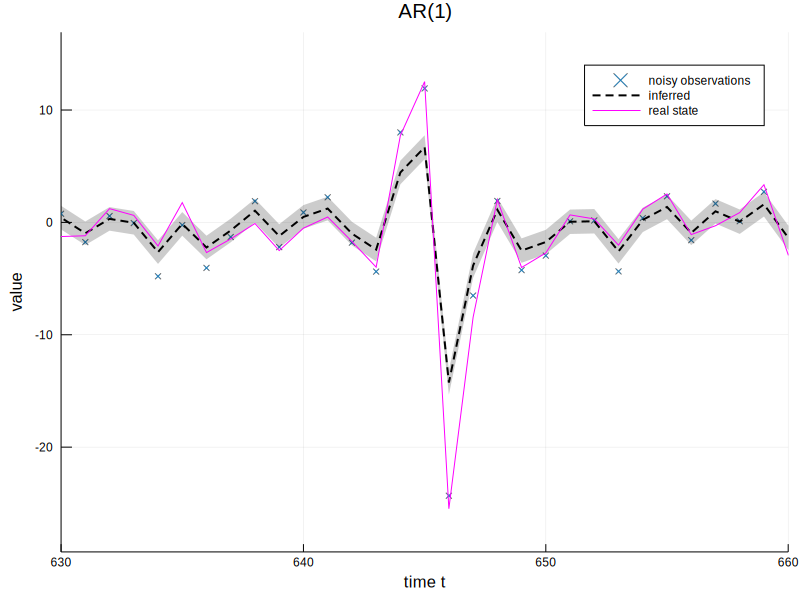

In [37]:
from = 630
upto = 660 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_ar, ribbon=sqrt.(v_ar),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(xlims=(from, upto),
            ylims=(minimum(y[from:upto]) - 5, maximum(y[from:upto]) + 5),
            size=(800, 600),
            xlabel="time t", ylabel="value", title="AR($ARorder)")

# RW model
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where $\gamma_y^{-1} = 2.0$

In [38]:
using .ForneyAR
ARorder = 1

1

In [39]:
grw, qrw = ForneyAR.buildGraphAR(ARorder)
ForneyLab.draw(grw)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11063464285640407686 -->
 
 11063464285640407686 
 
 clamp_1 
 
<!-- 11583151611404202263 -->
 
 11583151611404202263 
 
 placeholder_a_w_t 
 
<!-- 11698666025946348310 -->
 
 11698666025946348310 
 
 dot 
 dotproduct_1 
 
<!-- 11698666025946348310--11063464285640407686 -->
 
 11698666025946348310--11063464285640407686 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 1022910246339117701 -->
 
 1022910246339117701 
 
 AR 
 autoregression_1 
 
<!-- 11698666025946348310--1022910246339117701 -->
 
 11698666025946348310--1022910246339117701 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 6696459105321302921 -->
 
 6696459105321302921 
 
 placeholder_m_θ_t 
 
<!-- 14471184132541639672 -->
 
 14471184132541639672 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 14471184132541639672--6696459105321302921 -->
 
 14471184132541639672--6696459105321302921 
 
 m_θ_t 
 1 out 
 2 m 
 
<!-- 2856986143827305400 -->
 
 2856986143827305400 
 
 placeholder_w_θ_t 
 
<!-- 14471184132541639672--2856986143827305400 -->
 
 14471184132541639672--2856986143827305400 
 
 w_θ_t 
 1 out 
 3 w 
 
<!-- 14599208932325210113 -->
 
 14599208932325210113 
 
 placeholder_w_y_t 
 
<!-- 3398630051088111503 -->
 
 3398630051088111503 
 
 placeholder_y_t 
 
<!-- 4732357196054782474 -->
 
 4732357196054782474 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 3398630051088111503--4732357196054782474 -->
 
 3398630051088111503--4732357196054782474 
 
 y_t 
 1 out 
 1 out 
 
<!-- 6825099100987425307 -->
 
 6825099100987425307 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 13972919182490182134 -->
 
 13972919182490182134 
 
 placeholder_m_x_t_prev 
 
<!-- 6825099100987425307--13972919182490182134 -->
 
 6825099100987425307--13972919182490182134 
 
 m_x_t_prev 
 1 out 
 2 m 
 
<!-- 12857375409793875681 -->
 
 12857375409793875681 
 
 placeholder_w_x_t_prev 
 
<!-- 6825099100987425307--12857375409793875681 -->
 
 6825099100987425307--12857375409793875681 
 
 w_x_t_prev 
 1 out 
 3 w 
 
<!-- 7617603782560239257 -->
 
 7617603782560239257 
 
 placeholder_b_w_t 
 
<!-- 3508792859067524234 -->
 
 3508792859067524234 
 
 Gam 
 gamma_1 
 
<!-- 3508792859067524234--11583151611404202263 -->
 
 3508792859067524234--11583151611404202263 
 
 a_w_t 
 1 out 
 2 a 
 
<!-- 3508792859067524234--7617603782560239257 -->
 
 3508792859067524234--7617603782560239257 
 
 b_w_t 
 1 out 
 3 b 
 
<!-- 1022910246339117701--14471184132541639672 -->
 
 1022910246339117701--14471184132541639672 
 
 θ 
 1 out 
 3 θ 
 
<!-- 1022910246339117701--6825099100987425307 -->
 
 1022910246339117701--6825099100987425307 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 1022910246339117701--3508792859067524234 -->
 
 1022910246339117701--3508792859067524234 
 
 γ 
 1 out 
 4 γ 
 
<!-- 4732357196054782474--11698666025946348310 -->
 
 4732357196054782474--11698666025946348310 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 4732357196054782474--14599208932325210113 -->
 
 4732357196054782474--14599208932325210113 
 
 w_y_t 
 1 out 
 3 w

In [40]:
# RW
prs = Dict(:m_θ=>ones(ARorder), :w_θ=>huge*diagAR(ARorder),
           :m_x=>zeros(ARorder), :w_x=>diagAR(ARorder),
           :a=>0.00001, :b=>1.0)


# If Julia throws an error just ignore and re-run this (inference) block again
result = ForneyAR.inferAR(qrw, y, v_y, priors=prs, r_stats=true, vmp_iter=10);

Observed 100%|██████████████████████████████████████████| Time: 0:00:06


In [41]:
# Inspect the results
marginals = result[1]
FRW = result[3]
posteriors = result[4]

m_x = posteriors[:m_x]
w_x = posteriors[:w_x]
m_a = posteriors[:m_θ]
w_a = posteriors[:w_θ]
a = posteriors[:a]
b = posteriors[:b]

m_rw = [x[1] for x in m_x]
v_rw = [v_x[1]^-1 for v_x in w_x[1:end]];

logPDFsRW = [logPDF(x[t], m_rw[t], v_rw[t]) for t in 1:length(y)]
WMSEsRW = [wmse(x[1:t], [est[1] for est in m_x[1:t]], [est[1]^-1 for est in w_x[1:t]]) for t in 1:length(y)];

In [42]:
println("Coefs \n=========")
println("Estimated ", mean(marginals[:θ]))
println("True ", 1.0)

Coefs 
Estimated [1.0]
True 1.0


In [43]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:γ])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Process noise variance
Estimated 4.216676079546328
True 1.0

State
Mean [-1.16231]
Var [1.35659]


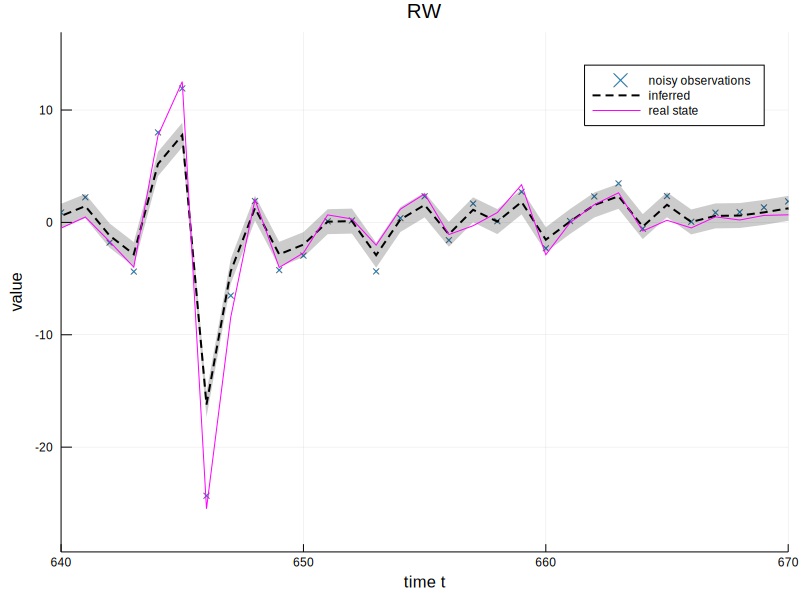

In [44]:
from = 640
upto = 670 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_rw, ribbon=sqrt.(v_rw),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlims=(from, upto),
            ylims=(minimum(y[from:upto]) - 5, maximum(y[from:upto]) + 5),
            size=(800, 600),
            xlabel="time t", ylabel="value", title="RW")

# Comparison (RW vs HAR)
To assess the performance of our model, we use the following metrics:
Free Energy:
$$F_t[q]\triangleq \int q(\mathbf{x}_t)\log\frac{q(\mathbf{x}_t)}{p(\mathbf{x}_t, y_t\big|\mathbf{y}_{1:t-1})}d\mathbf{x}_t$$

log PDF, i.e.:
$$-\frac{1}{2}\log{2\pi v_x}-\frac{(m_{x_{k}}-x_{k})^2}{2v_x}$$

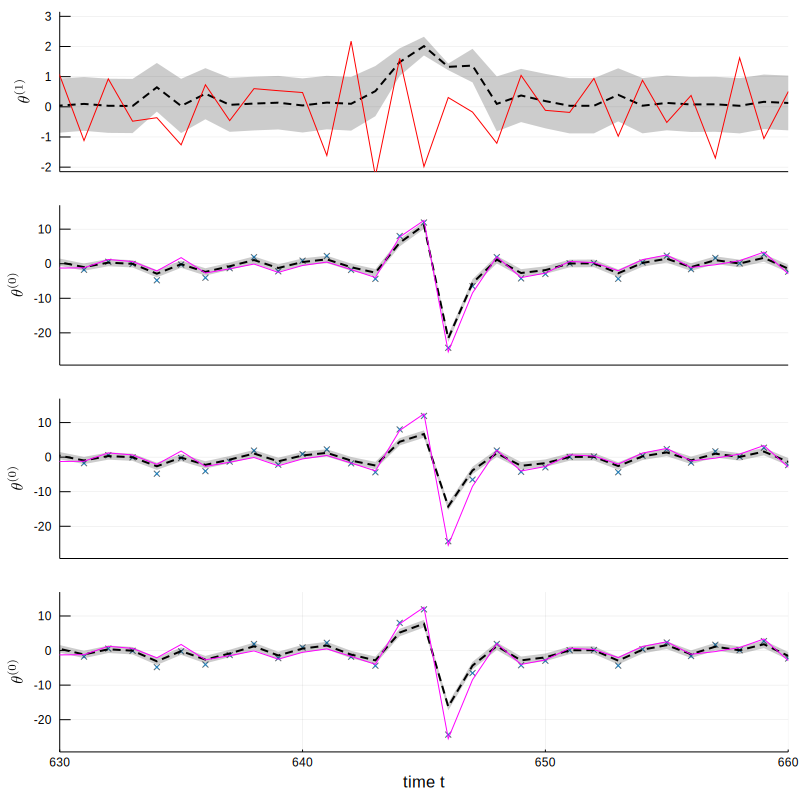

In [45]:
from = 630
upto = 660 # limit for building a graph 
scale = 1.0 # scale for the variance

plot(m_θ1t, ribbon=sqrt.(v_θ1t),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(θ[2:end], color=:red, label="real", title="")
pHAR1 = plot!(ylabel=L"\theta^{(1)}", title="", legend=false, xticks=[], ylims=[-2, 3])

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_xt, ribbon=sqrt.(v_xt),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state",  ylabel=L"\theta^{(0)}")
pHAR = plot!(title="", legend=false, ylims=(minimum(y[from:upto]) - 5, maximum(y[from:upto]) + 5), xticks=[])

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_ar, ribbon=sqrt.(v_ar),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(ylabel=L"\theta^{(0)}", ylims=(minimum(y[from:upto]) - 5, maximum(y[from:upto]) + 5), xticks=[])

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_rw, ribbon=sqrt.(v_rw),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="time t",  ylabel=L"\theta^{(0)}", ylims=(minimum(y[from:upto]) - 5, maximum(y[from:upto]) + 5))

plot(pHAR1, pHAR, pAR, pRW, xlims=(from, upto), 
    layout=(4,1),  size=(800, 800), legend=false)

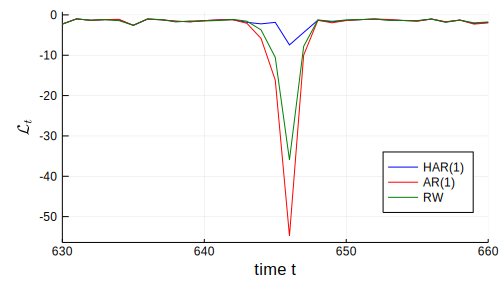

In [46]:
# log PDFs (the higher the better)
from = 630; upto = 660
plot(logPDFsHAR[1:end], color=:blue, label="HAR($HARorder)")
plot!(logPDFsAR[1:end], color=:red, label="AR($ARorder)", xlabel="time t", ylabel=L"\mathcal{L}_t", size=(500, 300), legend=:bottomright)
plt = plot!(logPDFsRW[1:end], color=:green, label="RW", xlims=(from, upto))
#savefig("logPDF.png")

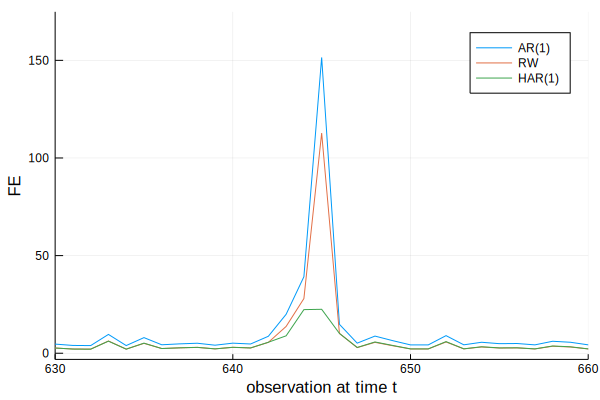

In [47]:
# Free energy (the lower the better)
from, upto = 630, 660
plot(FAR[2:end], label="AR($ARorder)", xlims=(from, upto))
plot!(FRW[2:end], label="RW", xlims=(from, upto))
plot!(FHAR[2:end], label="HAR($HARorder)", xlabel="observation at time t", ylabel="FE")

In [48]:
sum(logPDFsAR)

-1698.4880271479456

In [49]:
sum(logPDFsRW)

-1635.9427932774836

In [50]:
sum(logPDFsHAR)

-1487.9819171500433

In [51]:
sum(FAR)

5819.243350499076

In [52]:
sum(FRW)

3669.759358642003

In [53]:
sum(FHAR)

3467.1618595592463

# Animation

In [54]:
m_x = m_xt
v_x = v_xt # variances of estimated state (down layer)
m_θ = m_θ1t
v_θ = v_θ1t # variances of estimated state (up layer)

toshow = 20 # number of points to plot at once

anim = @animate for i in 300:length(m_x)-toshow
    down = plot(xticks = i:div(toshow, 2):i+toshow, size=(800, 600));
    ylims!(minimum(y[i:i+toshow]) - .1, maximum(y[i:i+toshow]) + .1);
    scatter!(collect(i:i+toshow), y[i:i+toshow], label="observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), m_x[i:i+toshow], ribbon=sqrt.(v_x[i:i+toshow]),
          linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black,
          label="inferred", title = "1st layer")
    
    plot!(collect(i:i+toshow), x[i:i+toshow], color = :magenta, linewidth = 1.0, label="real", xlabel="time t", ylabel=L"\theta^{(0)}")
    
    up = plot(xticks = i:div(toshow, 2):i+toshow, size=(800, 600)); ylims!(-5, 5);
    
    plot!(collect(i:i+toshow), m_θ[i:i+toshow], ribbon=sqrt.(v_θ[i:i+toshow]),
          linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black,
          label="inferred", title = "2d layer")
    
    plot!(collect(i:i+toshow), θ[i:i+toshow], color = :red, linewidth = 1.0, label="real", ylabel=L"\theta^{(1)}")
    
    plot(down, up, layout=(2,1),  size=(800, 600))
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmp9b0xPa", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000672.png", "000673.png", "000674.png", "000675.png", "000676.png", "000677.png", "000678.png", "000679.png", "000680.png", "000681.png"])

In [42]:
gif(anim, "gifs/1stHAR.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Desktop/IDA2020/gifs/1stHAR.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/Users/albertpod/Desktop/IDA2020/gifs/1stHAR.gif")

In [ ]:
# Plotting logPDF
anim = @animate for i in 1:length(logPDFsRW)
    s = plot(size=(800, 300))
    ylims!(-20, 0)
    xlims!(1, length(logPDFsRW))
    plot!(collect(1:i), logPDFsHAR[1:i], xlabel="time t", ylabel=L"\mathcal{L}_t", color=:blue, label="HAR($HARorder)")
    plot!(collect(1:i), logPDFsAR[1:i], color=:red, label="AR($HARorder)")
    plot!(collect(1:i), logPDFsRW[1:i], color=:green, label="RW")
end;

In [ ]:
gif(anim, "gifs/logPDFevo.gif", fps = 10)